In [1]:
pip install rarfile

In [7]:
import zipfile
import os
import rarfile

In [8]:
rar_path = "sensors_with_risk_2.rar"  # Change to uploaded file name
output_dir = "data"

try:
    with rarfile.RarFile(rar_path) as rf:
        rf.extractall(output_dir)
    print(f"Successfully extracted {rar_path} to {output_dir}")
except rarfile.Error as e:
    print(f"An error occurred: {e}")

Successfully extracted sensors_with_risk_2.rar to data


In [9]:
csv_file_path = "/content/data/sensors_with_risk_2.csv"

In [10]:
import pandas as pd
df = pd.read_csv(csv_file_path)

In [11]:
df.head()

,timestamp,uptimeNanos_lin,x_lin,y_lin,z_lin,uptimeNanos_acc,x_acc,y_acc,z_acc,uptimeNanos,...,z_gyro,start,finish,firstCollectionUptimeNanos,lastCollectionUptimeNanos,elapsedTimeNanos,smartphoneModel,androidVersion,acc_magnitude,risk_level
0,14/05/2016 10:54:33,11537817349260,0.085305,-0.322752,-0.106739,11537817349260,0.085305,-0.322752,9.69991,11537628641797,...,0.029619,2016-05-15 16:03:47.304-0300,2016-05-15 16:17:16.001-0300,11200022380290,12008698803207,808676422917,XT1058,5.1,9.705653,Intermediate
1,14/05/2016 10:54:33,11537817349260,0.085305,-0.322752,-0.106739,11537817349260,0.085305,-0.322752,9.69991,11537628641797,...,0.007163,2016-05-15 16:03:47.304-0300,2016-05-15 16:17:16.001-0300,11200022380290,12008698803207,808676422917,XT1058,5.1,9.705653,Intermediate
2,14/05/2016 10:54:33,11537817349260,0.085305,-0.322752,-0.106739,11537817349260,0.085305,-0.322752,9.69991,11537628641797,...,-0.007453,2016-05-15 16:03:47.304-0300,2016-05-15 16:17:16.001-0300,11200022380290,12008698803207,808676422917,XT1058,5.1,9.705653,Intermediate
3,14/05/2016 10:54:33,11537817349260,0.085305,-0.322752,-0.106739,11537817349260,0.085305,-0.322752,9.69991,11537746877720,...,0.029619,2016-05-15 16:03:47.304-0300,2016-05-15 16:17:16.001-0300,11200022380290,12008698803207,808676422917,XT1058,5.1,9.705653,Intermediate
4,14/05/2016 10:54:33,11537817349260,0.085305,-0.322752,-0.106739,11537817349260,0.085305,-0.322752,9.69991,11537746877720,...,0.007163,2016-05-15 16:03:47.304-0300,2016-05-15 16:17:16.001-0300,11200022380290,12008698803207,808676422917,XT1058,5.1,9.705653,Intermediate


In [12]:
df.isnull().sum()

,0
timestamp,0
uptimeNanos_lin,0
x_lin,0
y_lin,0
z_lin,0
uptimeNanos_acc,0
x_acc,0
y_acc,0
z_acc,0
uptimeNanos,0


In [13]:
df.duplicated().sum()

np.int64(0)

# Pipeline 1 – ANN with Engineered Features
- Goal: Convert your raw time-series into fixed-size feature windows feed to ANN.

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout , GRU
from tensorflow.keras.utils import to_categorical

In [15]:
# Keep only sensor columns + target
sensor_columns = ['x_acc', 'y_acc', 'z_acc', 'x_gyro', 'y_gyro', 'z_gyro', 'acc_magnitude']
X = df[sensor_columns].values
y = df['risk_level'].values

In [16]:
# Encode Target

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [17]:
# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical)

In [18]:
# Scale Features

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
# Build ANN Model

model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(4, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(y_categorical.shape[1], activation='softmax'))  # Softmax for classification

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
# Compile Model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Train Model

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=256, verbose=1)

Epoch 1/5
13025/13025 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - accuracy: 0.9576 - loss: 0.1822 - val_accuracy: 0.9977 - val_loss: 0.0135
Epoch 2/5
13025/13025 ━━━━━━━━━━━━━━━━━━━━ 77s 3ms/step - accuracy: 0.9847 - loss: 0.0430 - val_accuracy: 0.9978 - val_loss: 0.0130
Epoch 3/5
13025/13025 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.9850 - loss: 0.0424 - val_accuracy: 0.9976 - val_loss: 0.0135
Epoch 4/5
13025/13025 ━━━━━━━━━━━━━━━━━━━━ 79s 3ms/step - accuracy: 0.9850 - loss: 0.0424 - val_accuracy: 0.9973 - val_loss: 0.0141
Epoch 5/5
13025/13025 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - accuracy: 0.9850 - loss: 0.0425 - val_accuracy: 0.9977 - val_loss: 0.0134


In [22]:
# 8. Evaluate Model

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 99.77%


In [23]:
# 10. Predict on New Data
import numpy as np
predictions = model.predict(X_test[:5])
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))
print("Predictions:", predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Predictions: ['Danger' 'Intermediate' 'Intermediate' 'Intermediate' 'Intermediate']


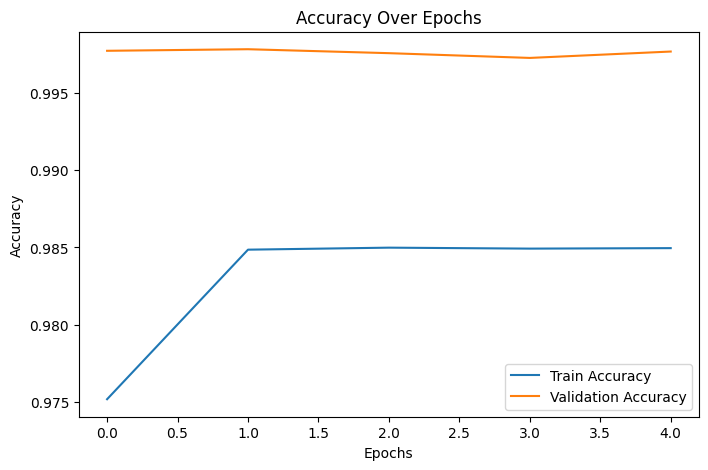

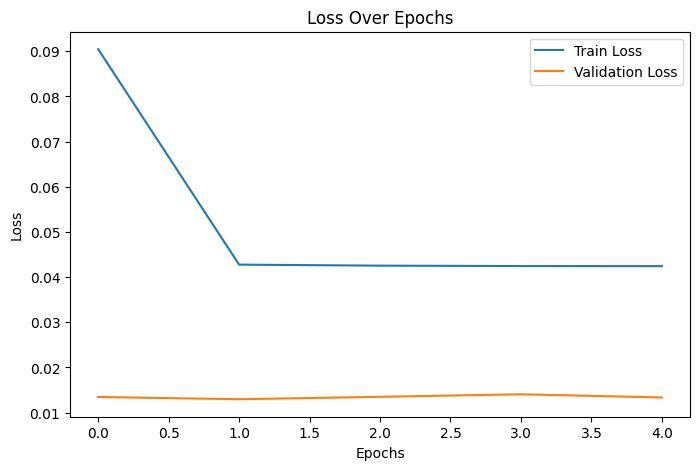

In [24]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

# LSTM Model

In [26]:
import tensorflow as tf

In [27]:
print("TensorFlow:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [28]:
# Load and sort data
df = df.sort_values(by='timestamp')  # ensure time order if timestamp present

In [29]:
# Features and target
feature_cols = ['x_acc','y_acc','z_acc','x_gyro','y_gyro','z_gyro','acc_magnitude']
X = df[feature_cols].astype('float32').values
y_raw = df['risk_level'].astype(str).values

In [30]:
# Encode labels
le = LabelEncoder()
y = le.fit_transform(y_raw)
n_classes = len(le.classes_)

In [32]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [33]:
# Train/Val/Test split chronologically
n = len(X_scaled)
test_size = int(0.2 * n)
val_size  = int(0.1 * n)
train_end = n - (val_size + test_size)
val_end   = n - test_size

In [34]:
X_train, y_train = X_scaled[:train_end], y[:train_end]
X_val,   y_val   = X_scaled[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X_scaled[val_end:], y[val_end:]

In [35]:
# Reshape into sequences
WINDOW = 64
STRIDE = 16

def create_sequences(X, y, window=WINDOW, stride=STRIDE):
    Xs, ys = [], []
    for i in range(0, len(X) - window, stride):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train, y_train)
X_val_seq,   y_val_seq   = create_sequences(X_val,   y_val)
X_test_seq,  y_test_seq  = create_sequences(X_test,  y_test)

print("Train sequences:", X_train_seq.shape, y_train_seq.shape)

Train sequences: (182337, 64, 7) (182337,)


In [44]:
# Build LSTM model
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(WINDOW, len(feature_cols))),
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(32),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

In [45]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64, 32)         │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,595 (57.01 KB)

 Trainable params: 14,595 (57.01 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Train
history2 = model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=5, batch_size=256, verbose=1)

Epoch 1/5
713/713 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.9593 - loss: 0.1962 - val_accuracy: 0.9761 - val_loss: 0.0767
Epoch 2/5
713/713 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.9895 - loss: 0.0350 - val_accuracy: 0.9758 - val_loss: 0.0747
Epoch 3/5
713/713 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9905 - loss: 0.0323 - val_accuracy: 0.9801 - val_loss: 0.0647
Epoch 4/5
713/713 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9911 - loss: 0.0306 - val_accuracy: 0.9782 - val_loss: 0.0649
Epoch 5/5
713/713 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9920 - loss: 0.0280 - val_accuracy: 0.9805 - val_loss: 0.0619


In [48]:
# Evaluate
loss, acc = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"Test Accuracy: {acc:.4f} | Test Loss: {loss:.4f}")

Test Accuracy: 0.9870 | Test Loss: 0.0439


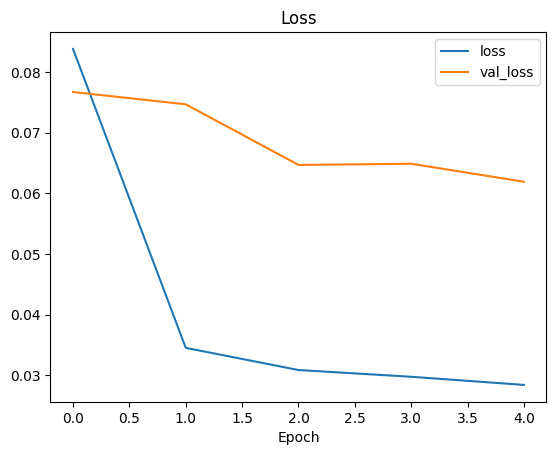

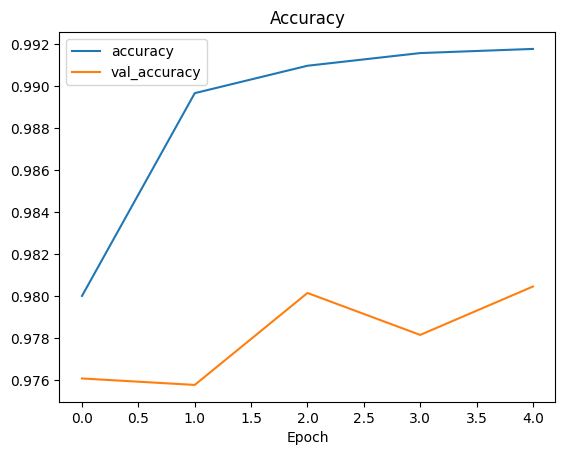

In [49]:
# Plot training curves
plt.figure()
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss'); plt.xlabel('Epoch'); plt.show()


plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.legend(); plt.title('Accuracy'); plt.xlabel('Epoch'); plt.show()

# GRU Model

In [50]:
# Train-Test Split

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [54]:
X_train = np.expand_dims(X_train, axis=1)  # shape becomes (samples, 1, features)
X_test = np.expand_dims(X_test, axis=1)

In [68]:
# GRU Model
model = Sequential([GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.5),
    GRU(16),
    Dropout(0.5),
    Dense(16, activation='tanh'),
    Dense(y_train.shape[1], activation='softmax')
])

In [69]:
# Compile & Train

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [70]:
history3 = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=1024
)

Epoch 1/5
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.9765 - loss: 0.1122 - val_accuracy: 0.9992 - val_loss: 0.0021
Epoch 2/5
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - accuracy: 0.9985 - loss: 0.0041 - val_accuracy: 0.9992 - val_loss: 0.0016
Epoch 3/5
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - accuracy: 0.9990 - loss: 0.0027 - val_accuracy: 0.9993 - val_loss: 0.0018
Epoch 4/5
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.9992 - loss: 0.0023 - val_accuracy: 0.9986 - val_loss: 0.0033
Epoch 5/5
2850/2850 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.9992 - loss: 0.0020 - val_accuracy: 0.9989 - val_loss: 0.0043


In [71]:
# Evaluate

loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

 3854/26049 ━━━━━━━━━━━━━━━━━━━━ 1:27 4ms/step - accuracy: 0.9981 - loss: 0.0080

KeyboardInterrupt: 

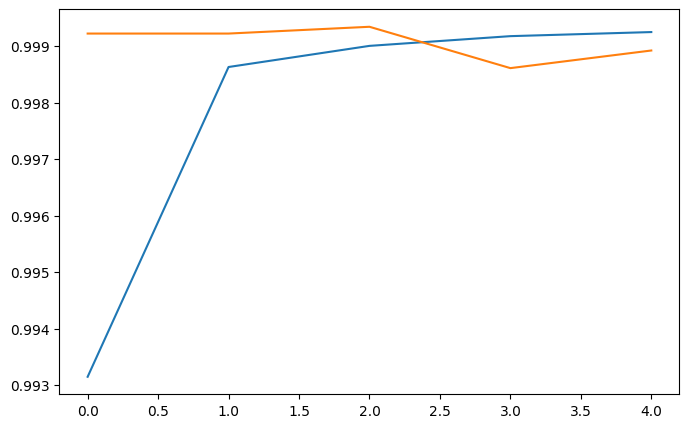

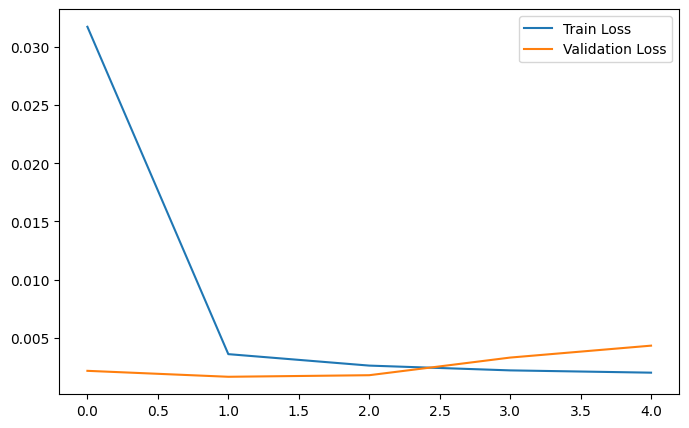

In [74]:
plt.figure(figsize=(8,5))
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')

plt.figure(figsize=(8,5))
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()